# Thư viện 

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import optuna
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import xgboost as xgb
from prophet import Prophet
import torch
import torch.nn as nn
import torch.optim as optim

# Chuẩn bị dữ liệu

In [63]:
sales_df=pd.read_csv(r"D:\Du An\Data FLow\v1\data\FORECASTING BUSINESS PERFORMANCE.csv")
geo_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\geography.csv")
product_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\product.csv")

In [64]:
sales_info = sales_df.info()
geo_info = geo_df.info()
product_info = product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976243 entries, 0 to 976242
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductID  976243 non-null  int64 
 1   Date       976243 non-null  object
 2   Zip        976243 non-null  int64 
 3   Units      976243 non-null  int64 
 4   Revenue    976202 non-null  object
 5   COGS       976243 non-null  object
dtypes: int64(3), object(3)
memory usage: 44.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39948 entries, 0 to 39947
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Zip       39948 non-null  int64 
 1   City      39948 non-null  object
 2   State     39948 non-null  object
 3   Region    39948 non-null  object
 4   District  39948 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2412 entries, 0 to 2411
Data columns (total 4

In [65]:

# Loại bỏ ký tự tiền tệ '$' và dấu ',' trong các cột Revenue, COGS
for col in ['Revenue', 'COGS']:
    if col in sales_df.columns:
        sales_df[col] = sales_df[col].astype(str).str.replace(r'[\$,]', '', regex=True).astype(float)

# Chuyển đổi cột Date về kiểu datetime
if 'Date' in sales_df.columns:
    sales_df['Date'] = pd.to_datetime(sales_df['Date'])

# Xử lý giá trị thiếu (Missing Values)
sales_df.fillna(0, inplace=True)  # Thay thế giá trị thiếu bằng 0

# Gộp dữ liệu với geography.csv nếu có cột Zip
if 'Zip' in sales_df.columns and 'Zip' in geo_df.columns:
    sales_df = sales_df.merge(geo_df, on='Zip', how='left')

# Gộp dữ liệu với product.csv nếu có cột Product ID
if 'Product ID' in sales_df.columns and 'Product ID' in product_df.columns:
    sales_df = sales_df.merge(product_df, on='Product ID', how='left')


# Hiển thị 5 dòng đầu tiên để kiểm tra
print(sales_df.head())


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\2307088610.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sales_df['Date'] = pd.to_datetime(sales_df['Date'])


   ProductID       Date    Zip  Units    Revenue      COGS  \
0       1228 2013-07-31  78773     12   19648.44  12309.75   
1        781 2014-03-12  90501     16   20351.52  13497.13   
2       2090 2013-11-29  44460     26  111367.62  91488.50   
3       1116 2018-08-29  30122     12   36280.44  21967.81   
4        993 2013-04-27  75789     14   55557.18  48645.87   

                 City State   Region      District  
0          Austin, TX    TX  Central  District #23  
1        Torrance, CA    CA     West  District #37  
2           Salem, OH    OH     East  District #14  
3  Lithia Springs, GA    GA     East  District #09  
4           Troup, TX    TX  Central  District #24  


In [66]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'], errors='coerce')
sales_df['Revenue'] = pd.to_numeric(sales_df['Revenue'], errors='coerce')
sales_df['COGS'] = pd.to_numeric(sales_df['COGS'], errors='coerce')

In [67]:
sales_df['Revenue'].fillna(sales_df['Revenue'].median(), inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\912488127.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_df['Revenue'].fillna(sales_df['Revenue'].median(), inplace=True)


In [68]:
sales_df['Year'] = sales_df['Date'].dt.year
sales_df['Month'] = sales_df['Date'].dt.month
sales_df['Quarter'] = sales_df['Date'].dt.to_period('Q')

In [69]:
sales_df

,ProductID,Date,Zip,Units,Revenue,COGS,City,State,Region,District,Year,Month,Quarter
0,1228,2013-07-31,78773,12,19648.44,12309.75,"Austin, TX",TX,Central,District #23,2013,7,2013Q3
1,781,2014-03-12,90501,16,20351.52,13497.13,"Torrance, CA",CA,West,District #37,2014,3,2014Q1
2,2090,2013-11-29,44460,26,111367.62,91488.50,"Salem, OH",OH,East,District #14,2013,11,2013Q4
3,1116,2018-08-29,30122,12,36280.44,21967.81,"Lithia Springs, GA",GA,East,District #09,2018,8,2018Q3
4,993,2013-04-27,75789,14,55557.18,48645.87,"Troup, TX",TX,Central,District #24,2013,4,2013Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
976238,2213,2013-08-12,15135,1,1070.37,749.79,"Mckeesport, PA",PA,East,District #13,2013,8,2013Q3
976239,2213,2011-12-04,80120,1,1070.37,749.79,"Littleton, CO",CO,Central,District #20,2011,12,2011Q4
976240,2213,2011-05-29,30028,1,1070.37,749.79,"Cumming, GA",GA,East,District #09,2011,5,2011Q2
976241,2213,2014-04-01,65279,1,1070.37,749.79,"Rocheport, MO",MO,Central,District #29,2014,4,2014Q2


# EDA

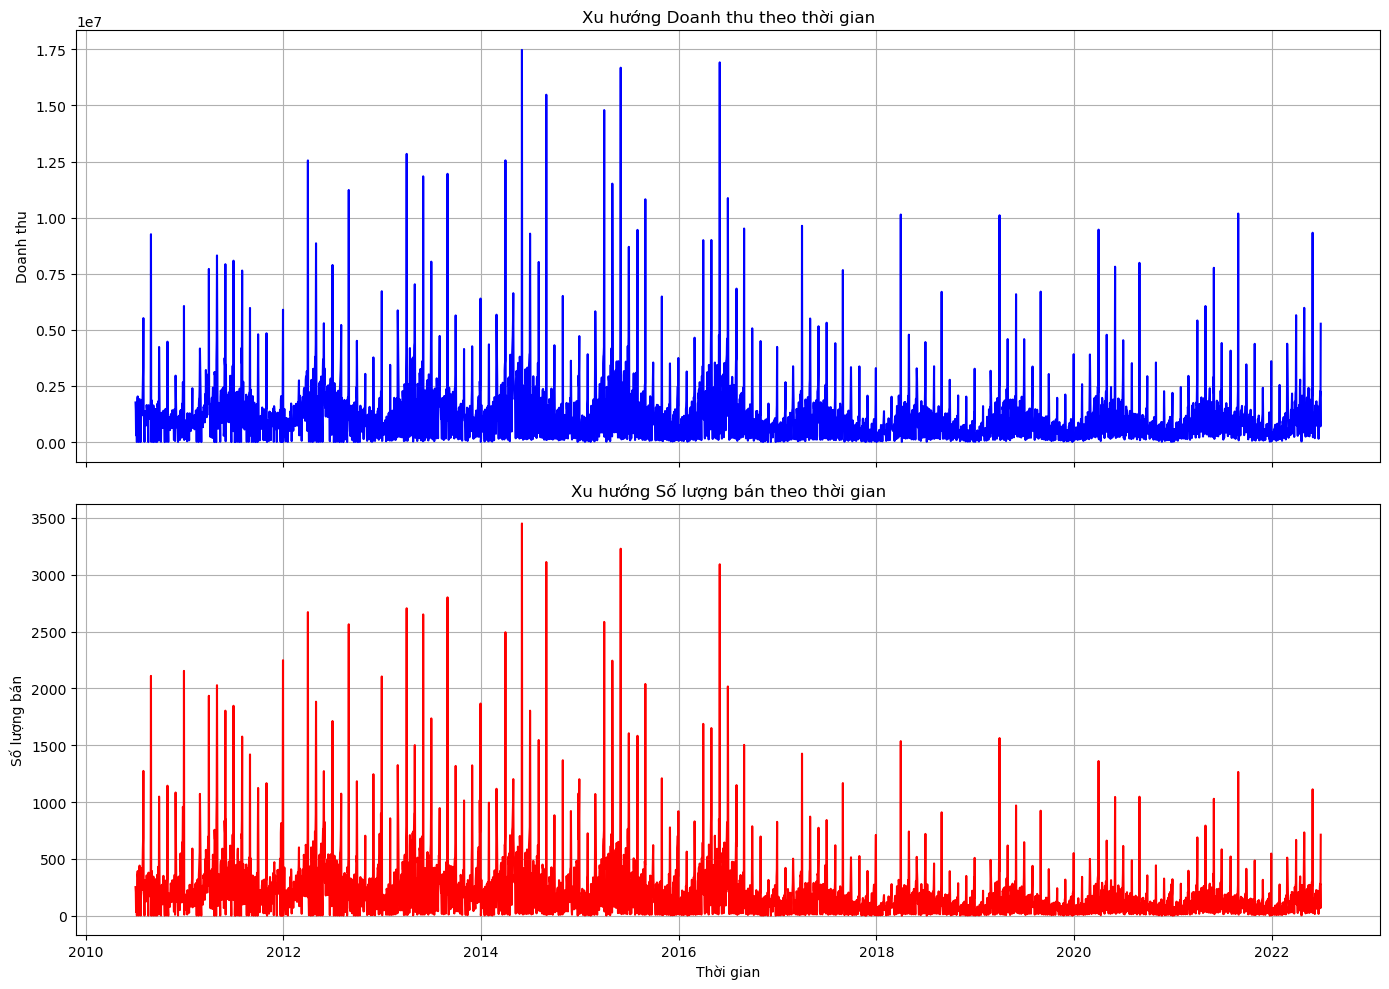

In [70]:
sales_trend = sales_df.groupby('Date').agg({'Revenue': 'sum', 'Units': 'sum'}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

sns.lineplot(data=sales_trend, x='Date', y='Revenue', ax=axes[0], color='blue')
axes[0].set_title("Xu hướng Doanh thu theo thời gian")
axes[0].set_ylabel("Doanh thu")
axes[0].grid(True)

sns.lineplot(data=sales_trend, x='Date', y='Units', ax=axes[1], color='red')
axes[1].set_title("Xu hướng Số lượng bán theo thời gian")
axes[1].set_ylabel("Số lượng bán")
axes[1].set_xlabel("Thời gian")
axes[1].grid(True)

plt.tight_layout()
plt.show()

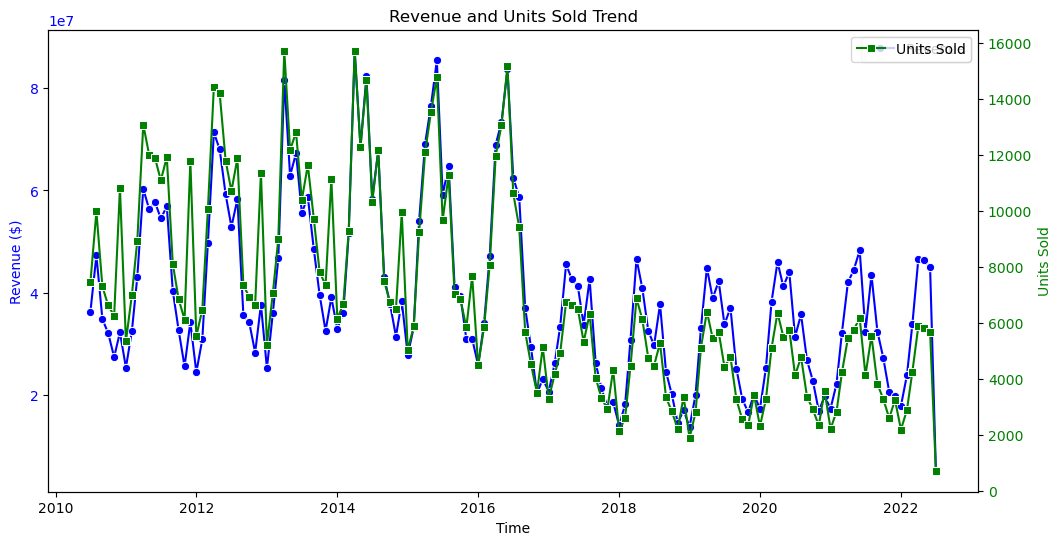

In [71]:
monthly_sales = sales_df.groupby(["Year", "Month"]).agg({"Revenue": "sum", "Units": "sum"}).reset_index()
monthly_sales["Time"] = pd.to_datetime(monthly_sales[["Year", "Month"]].assign(day=1))
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=monthly_sales, x="Time", y="Revenue", marker="o", label="Revenue", ax=ax1, color="b")
ax1.set_ylabel("Revenue ($)", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
sns.lineplot(data=monthly_sales, x="Time", y="Units", marker="s", label="Units Sold", ax=ax2, color="g")
ax2.set_ylabel("Units Sold", color="g")
ax2.tick_params(axis="y", labelcolor="g")
plt.title("Revenue and Units Sold Trend")
plt.xlabel("Time")
plt.show()

có thể thấy doanh thu và số lượng có sự dao động theo mùa rõ ràng. biến động giữa các tháng cũng rất lớn. quan sát biểu đồ có thể thấy doanh thu và doanh số có sự khác biệt rất lớn giữa 2 giai đoạn:2010- 2017 và 2017-2022

Giai đoạn 2010-2016 có sự tăng trưởng mạnh, đồng thời biến động cũng lớn và đjay đỉnh vào giai đoạn 2014-2016.Sự biến động mạnh và có sự lặp lại thể hiện sự giao động này có tính mùa vụ và ảnh hưởng bởi các sự kiện đặc biệt.

từ sau năm 2016, doanh thu và doanh số đều đồng loạt giảm mạnh, có thể thấy được sự thay đổi trong kinh doanh của công ty hoặc do yếu tố thị trường. Có thể kể tới như đối thủ cạnh tranh, thay đổi hành vi chuyển qua mua hàng online thay vì cửa hàng vật lý, hoặc do ảnh hưởng của kinh tế vĩ mô

Quan sát biểu đồ ta thấy trong năm sẽ có 2 thời điểm doanh thu và doanh số cao nhất là khoảng xuân hạ và thu đông

Điều này có thể liên quan đến các dịp mua sắm lớn như Black Friday, Giáng Sinh, hoặc thay đổi mùa thời trang (Xuân-Hạ, Thu-Đông)

In [72]:
sales_df ['Date'] = pd.to_datetime(sales_df['Date'])

In [73]:
sales_trend = sales_df.groupby('Date').agg({'Revenue': 'sum', 'Units': 'sum'}).reset_index()

In [74]:
sales_yearly = sales_df.groupby('Year').agg({'Revenue': 'sum'}).reset_index()
sales_monthly = sales_df.groupby('Month').agg({'Revenue': 'sum'}).reset_index()
sales_quarterly = sales_df.groupby('Quarter').agg({'Revenue': 'sum'}).reset_index()

In [75]:
sales_quarterly['Quarter'] = pd.Categorical(sales_quarterly['Quarter'], 
                                            categories=sorted(sales_quarterly['Quarter'].unique()), 
                                            ordered=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\3944187640.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_yearly, x='Year', y='Revenue', ax=axes[0], palette='Blues_d')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\3944187640.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_monthly, x='Month', y='Revenue', ax=axes[1], palette='Reds_d')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\3944187640.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_quarterly, x='Quarter', y='Revenue', ax=axes[2], 

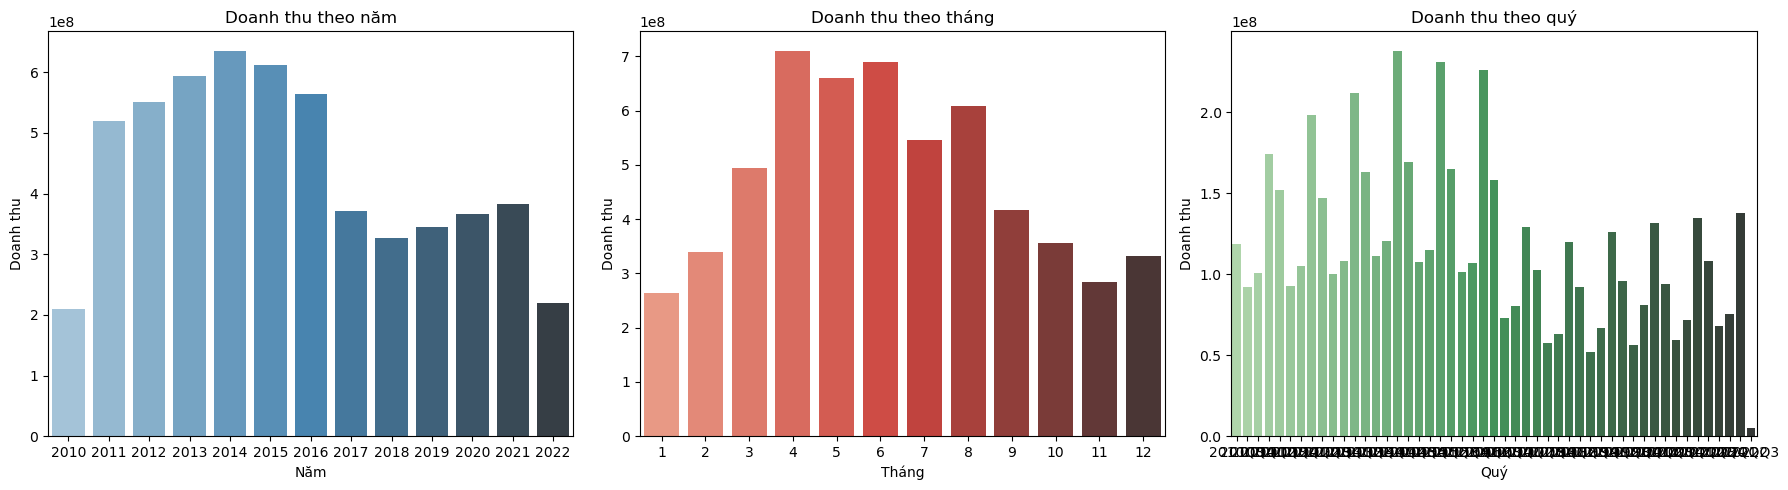

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=sales_yearly, x='Year', y='Revenue', ax=axes[0], palette='Blues_d')
axes[0].set_title("Doanh thu theo năm")
axes[0].set_xlabel("Năm")
axes[0].set_ylabel("Doanh thu")

sns.barplot(data=sales_monthly, x='Month', y='Revenue', ax=axes[1], palette='Reds_d')
axes[1].set_title("Doanh thu theo tháng")
axes[1].set_xlabel("Tháng")
axes[1].set_ylabel("Doanh thu")

sns.barplot(data=sales_quarterly, x='Quarter', y='Revenue', ax=axes[2], palette='Greens_d')
axes[2].set_title("Doanh thu theo quý")
axes[2].set_xlabel("Quý")
axes[2].set_ylabel("Doanh thu")

plt.tight_layout()
plt.show()

một số biểu đồ về phân bổ doanh thu theo năm, tháng

In [77]:
sales_region = sales_df.groupby('Region').agg({'Revenue': 'sum'}).reset_index()
top_products = sales_df.groupby('ProductID').agg({'Revenue': 'sum'}).reset_index().sort_values(by='Revenue', ascending=False).head(10)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\341673232.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_region, x='Revenue', y='Region', ax=axes[0], palette='coolwarm')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\341673232.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x='ProductID', y='Revenue', ax=axes[1], palette='magma')


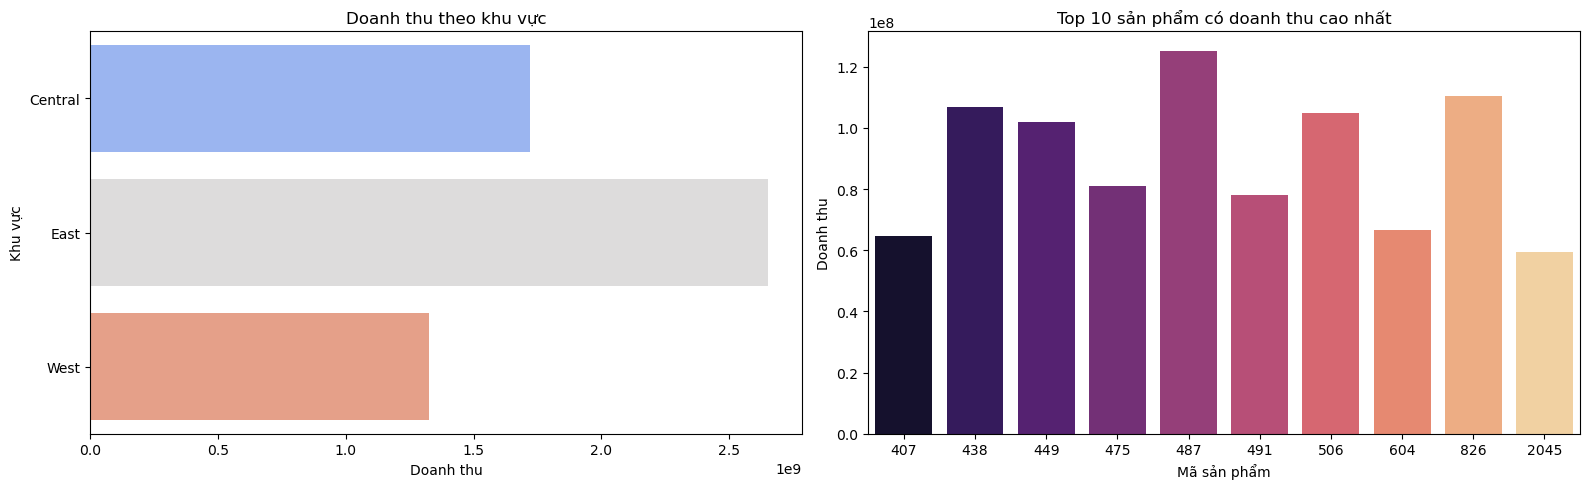

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(data=sales_region, x='Revenue', y='Region', ax=axes[0], palette='coolwarm')
axes[0].set_title("Doanh thu theo khu vực")
axes[0].set_xlabel("Doanh thu")
axes[0].set_ylabel("Khu vực")

sns.barplot(data=top_products, x='ProductID', y='Revenue', ax=axes[1], palette='magma')
axes[1].set_title("Top 10 sản phẩm có doanh thu cao nhất")
axes[1].set_xlabel("Mã sản phẩm")
axes[1].set_ylabel("Doanh thu")

plt.tight_layout()
plt.show()

khu vực phía Đông mang lại doanh thu cao nhất. đây là điều dễ hiểu vị phía Đông nước Mỹ là nơi tập trung chủ yếu của những trung tâm kinh tế, chính trị

rất tiếc là k có thông tin tên sản phẩm để phân tích sâu hơn

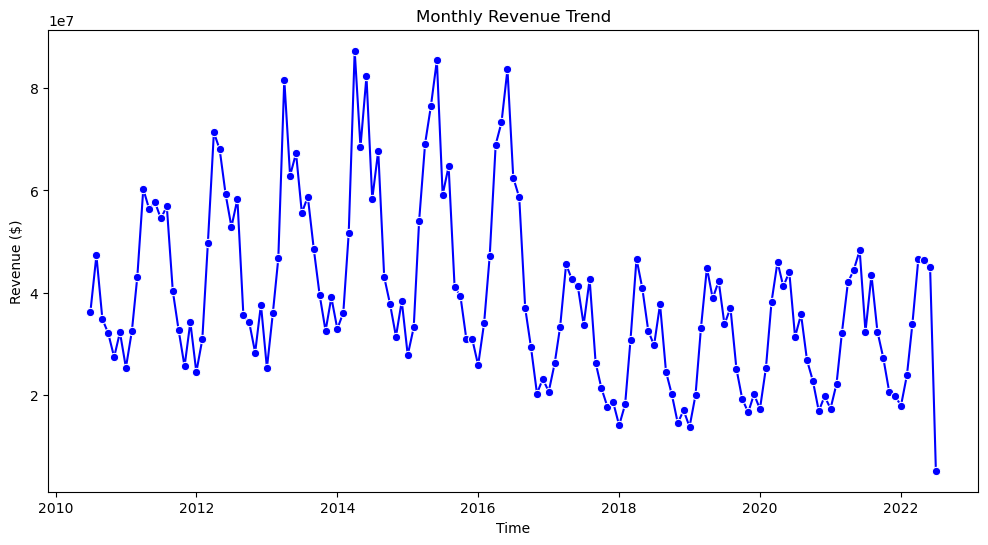

In [79]:
monthly_revenue = sales_df.groupby(["Year", "Month"]).agg({"Revenue": "sum"}).reset_index()
monthly_revenue["Time"] = pd.to_datetime(monthly_revenue[["Year", "Month"]].assign(day=1))
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue, x="Time", y="Revenue", marker="o", color="blue")
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue ($)")
plt.xlabel("Time")
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\1019782565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x="ProductID", y="Units", palette="viridis")


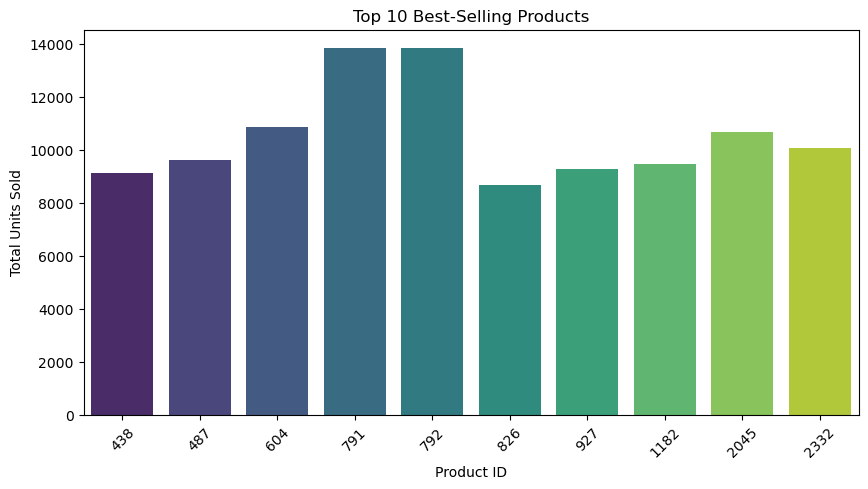

In [80]:
top_products = sales_df.groupby("ProductID")["Units"].sum().reset_index().sort_values(by="Units", ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(data=top_products, x="ProductID", y="Units", palette="viridis")
plt.title("Top 10 Best-Selling Products")
plt.ylabel("Total Units Sold")
plt.xlabel("Product ID")
plt.xticks(rotation=45)
plt.show()

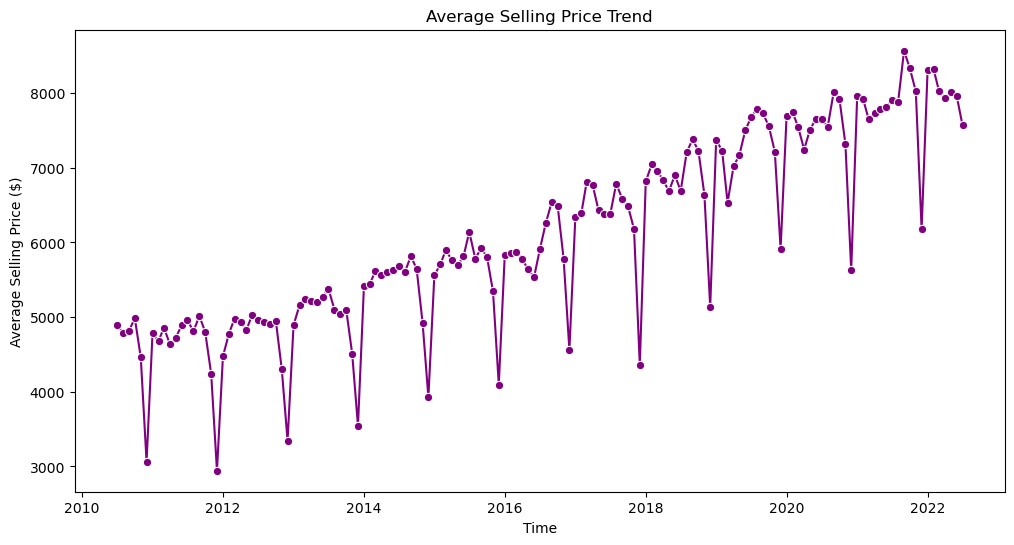

In [81]:
sales_df["ASP"] = sales_df["Revenue"] / sales_df["Units"]
monthly_asp = sales_df.groupby(["Year", "Month"]).agg({"ASP": "mean"}).reset_index()
monthly_asp["Time"] = pd.to_datetime(monthly_asp[["Year", "Month"]].assign(day=1))
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_asp, x="Time", y="ASP", marker="o", color="purple")
plt.title("Average Selling Price Trend")
plt.ylabel("Average Selling Price ($)")
plt.xlabel("Time")
plt.show()

có thể thấy tuy doanh thu vào doanh số sau năm 2016 giảm mạnh nhưng giá bán trung bình có xu hướng tăng ổn định theo thời gian. những thời điểm giá giảm sâu tương đồng với thời điểm doanh thu và doanh số cũng là thấp nhất. Từ đó ta nhận thấy những thời điểm có sự kiện hoặc mùa thời trang là thời điểm mang lại nguồn doanh thu chính cho doanh nghiệp, người mua sẵn sàng trả giá cao để mua trong thời điểm này.

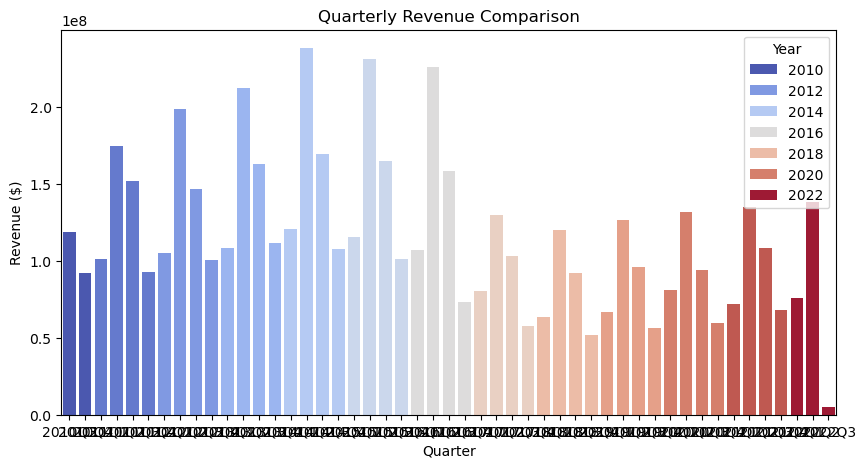

In [82]:
quarterly_sales = sales_df.groupby(["Year", "Quarter"]).agg({"Revenue": "sum"}).reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=quarterly_sales, x="Quarter", y="Revenue", hue="Year", palette="coolwarm")
plt.title("Quarterly Revenue Comparison")
plt.ylabel("Revenue ($)")
plt.xlabel("Quarter")
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\18469198.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_high_price, x="ProductID", y="ASP", palette="Reds_r", ax=ax[0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\18469198.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_low_price, x="ProductID", y="ASP", palette="Blues_r", ax=ax[1])


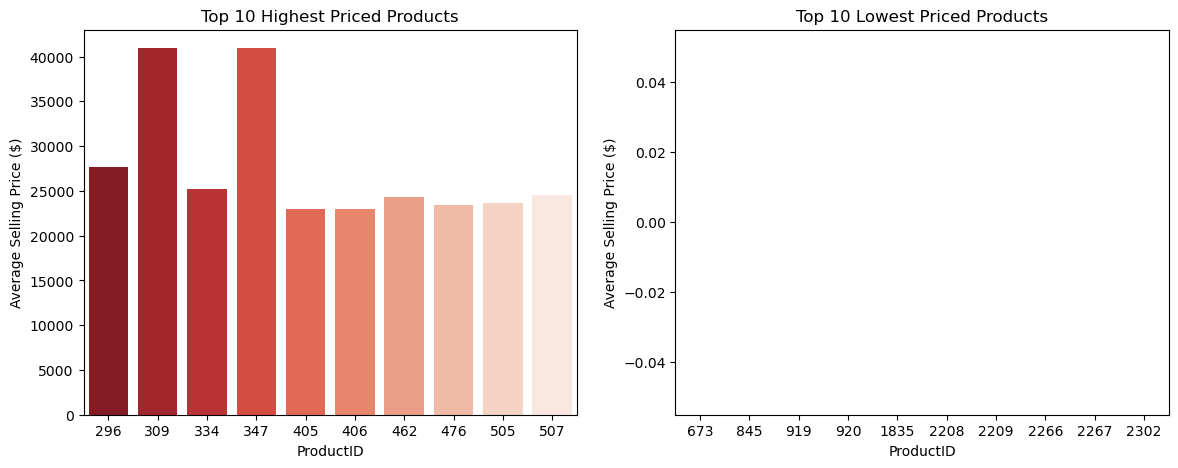

In [83]:
product_pricing = sales_df.groupby("ProductID")["ASP"].mean().reset_index()
top_high_price = product_pricing.sort_values(by="ASP", ascending=False).head(10)
top_low_price = product_pricing.sort_values(by="ASP", ascending=True).head(10)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=top_high_price, x="ProductID", y="ASP", palette="Reds_r", ax=ax[0])
ax[0].set_title("Top 10 Highest Priced Products")
ax[0].set_ylabel("Average Selling Price ($)")
sns.barplot(data=top_low_price, x="ProductID", y="ASP", palette="Blues_r", ax=ax[1])
ax[1].set_title("Top 10 Lowest Priced Products")
ax[1].set_ylabel("Average Selling Price ($)")
plt.show()

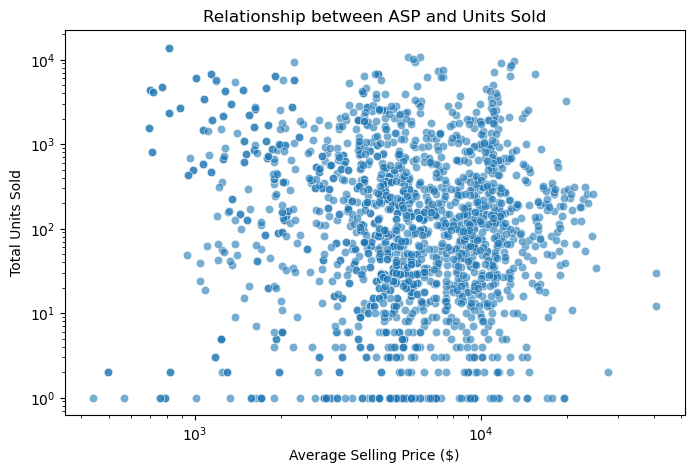

In [84]:
price_vs_sales = sales_df.groupby("ProductID").agg({"ASP": "mean", "Units": "sum"}).reset_index()
plt.figure(figsize=(8, 5))
sns.scatterplot(data=price_vs_sales, x="ASP", y="Units", alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.title("Relationship between ASP and Units Sold")
plt.xlabel("Average Selling Price ($)")
plt.ylabel("Total Units Sold")
plt.show()

Dữ liệu tập trung ở mức giá từ $1,000 - $10,000

Hầu hết các điểm tập trung quanh mức giá $1,000 - $10,000, với số lượng bán khá đa dạng.
Ở mức giá thấp (<$1,000), có một số trường hợp bán được rất nhiều sản phẩm nhưng cũng có một số điểm bán rất ít.
Ở mức giá cao (>$10,000), vẫn có sản phẩm bán tốt nhưng tần suất giảm dần.

Như đã nói, không phải lúc nào giá cao cũng làm giảm số lượng bán

Các điểm gần đáy biểu đồ (Units Sold = 1-10) cho thấy có những mặt hàng có giá cao nhưng chỉ bán được rất ít sản phẩm.
Đây có thể là sản phẩm cao cấp, luxury hoặc dòng hàng hiếm.


In [85]:
if "Category" in sales_df.columns:
    category_sales = sales_df.groupby("Category").agg({"Revenue": "sum", "Units": "sum"}).reset_index()
    plt.figure(figsize=(12, 5))
    sns.barplot(data=category_sales, x="Category", y="Revenue", palette="coolwarm")
    plt.title("Revenue by Product Category")
    plt.ylabel("Total Revenue ($)")
    plt.xlabel("Category")
    plt.xticks(rotation=45)
    plt.show()

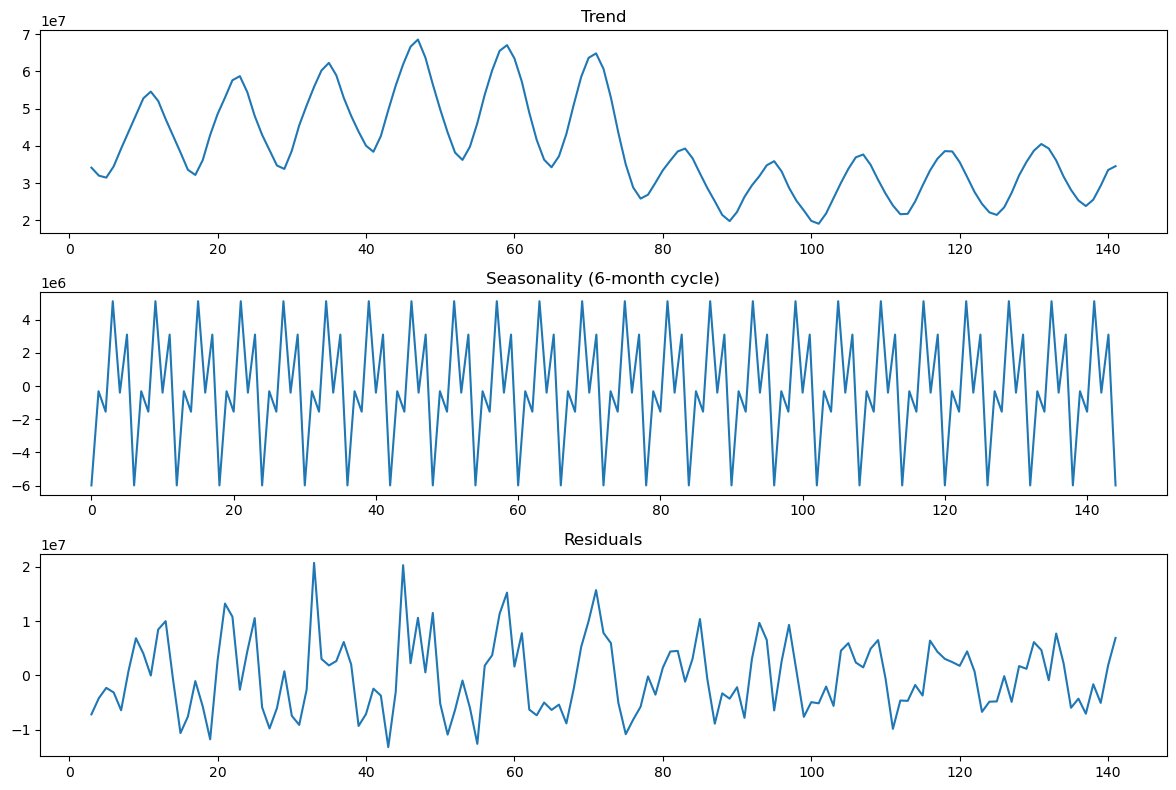

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14288\4112786371.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg_revenue.index, y=monthly_avg_revenue.values, palette="coolwarm")


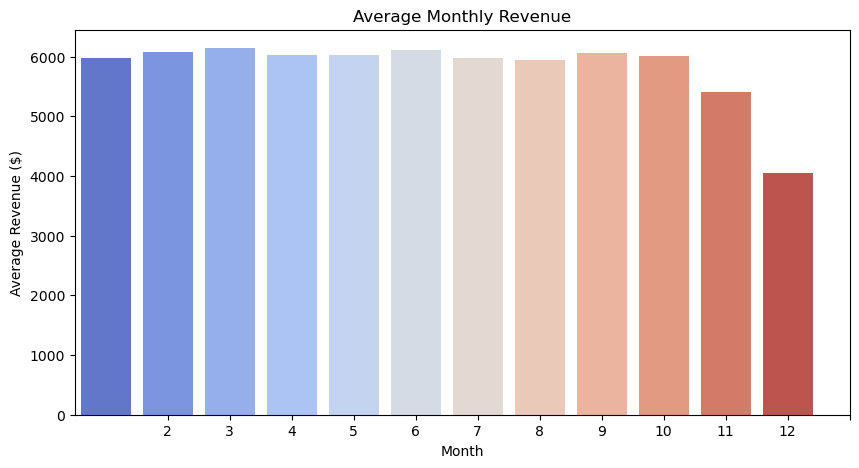

In [86]:
try:
    decomp = seasonal_decompose(monthly_revenue["Revenue"], model="additive", period=6)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
    decomp.trend.plot(ax=ax1, title="Trend")
    decomp.seasonal.plot(ax=ax2, title="Seasonality (6-month cycle)")
    decomp.resid.plot(ax=ax3, title="Residuals")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Decomposition failed:", e)

monthly_avg_revenue = sales_df.groupby("Month")["Revenue"].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_avg_revenue.index, y=monthly_avg_revenue.values, palette="coolwarm")
plt.title("Average Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Average Revenue ($)")
plt.xticks(range(1, 13))
plt.show()

Chuỗi có xu hướng rõ ràng, với giai đoạn tăng trưởng rồi suy giảm.
Biến động khá mạnh và không có xu hướng rõ ràng.
Điều này có thể do các yếu tố bất thường, sự kiện đặc biệt hoặc yếu tố ngẫu nhiên không thể dự báo được bằng mô hình tuyến tính đơn giản.

# Mô hình

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from prophet import Prophet
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

In [ ]:
def ensure_stationarity(df, column, max_diff=2):
    df_adjusted = df.copy()
    series = df[column].dropna()
    diffs = 0
    p_value = adfuller(series)[1]
    
    print(f"\nChecking stationarity for {column}:")
    print(f"Initial p-value: {p_value:.4f}")
    
    while p_value > 0.05 and diffs < max_diff:
        series = series.diff().dropna()
        df_adjusted[column] = df_adjusted[column].diff()
        diffs += 1
        p_value = adfuller(series)[1] if len(series) > 0 else 1.0
        print(f"After diff {diffs}: p-value = {p_value:.4f}")
    
    if diffs == max_diff and p_value > 0.05:
        print(f"Warning: {column} still non-stationary after {max_diff} differences")
    else:
        print(f"{column} is stationary after {diffs} differences")
    
    df_adjusted = df_adjusted.dropna().fillna(method='ffill')
    return df_adjusted

In [ ]:
def evaluate(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} Results:")
    print(f"  R2: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    return y_pred

In [ ]:
def plot_results(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Thực tế', color='blue')
    plt.plot(y_pred, label=model_name, linestyle='--', color='orange')
    plt.title(f'Dự báo Doanh thu với {model_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Doanh thu')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 1. ARIMA


In [ ]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [ ]:
def run_arima():
    
    print("\n=== ARIMA Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')
    
    model = ARIMA(train_stationary['Revenue'], order=(1, 1, 1)).fit()
    y_pred = model.forecast(steps=len(test_stationary))
    y_true = test_stationary['Revenue']
    
    y_pred = evaluate(y_true, y_pred, "ARIMA")
    plot_results(y_true, y_pred, "ARIMA")

In [ ]:
run_arima()


=== ARIMA Model ===


MemoryError: Unable to allocate 722. MiB for an array with shape (105, 901443) and data type float64

# 2. LSTM


In [ ]:
def run_lstm():

    print("\n=== LSTM Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')
    
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_stationary[['Revenue']])
    test_scaled = scaler.transform(test_stationary[['Revenue']])
    
    def create_sequences(data, seq_length=10):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length, 0])
        return np.array(X), np.array(y)
    
    seq_length = 10
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)
    
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=32, 
              callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=1)
    
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)[:, 0]
    y_true = test_stationary['Revenue'][seq_length:]
    
    y_pred = evaluate(y_true, y_pred, "LSTM")
    plot_results(y_true, y_pred, "LSTM")

In [ ]:
run_lstm()

# 3. XGBoost


In [ ]:
def run_xgboost():
    from xgboost import XGBRegressor
    
    print("\n=== XGBoost Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')
    train_stationary_units = ensure_stationarity(train, 'Units')
    test_stationary_units = ensure_stationarity(test, 'Units')
    
    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
    model.fit(train_stationary_units[['Units']], train_stationary['Revenue'])
    y_pred = model.predict(test_stationary_units[['Units']])
    y_true = test_stationary['Revenue']
    
    y_pred = evaluate(y_true, y_pred, "XGBoost")
    plot_results(y_true, y_pred, "XGBoost")

In [ ]:
run_xgboost()

# 4. Transformer (patchTST)

In [ ]:
def run_patchtst():
    from neuralforecast import NeuralForecast
    from neuralforecast.models import PatchTST
    
    print("\n=== PatchTST Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')
    
    train_df = pd.DataFrame({
        'ds': pd.date_range(start='2020-01-01', periods=len(train_stationary), freq='D'),  # Adjust start date
        'y': train_stationary['Revenue'],
        'unique_id': '1'
    })
    test_df = pd.DataFrame({
        'ds': pd.date_range(start=train_df['ds'].iloc[-1] + pd.Timedelta(days=1), 
                           periods=len(test_stationary), freq='D'),
        'unique_id': '1'
    })
    
    nf = NeuralForecast(models=[PatchTST(input_size=10, h=1, max_steps=500)], freq='D')
    nf.fit(df=train_df)
    y_pred = nf.predict(df=test_df)['PatchTST'].values
    y_true = test_stationary['Revenue']
    
    y_pred = evaluate(y_true, y_pred, "PatchTST")
    plot_results(y_true, y_pred, "PatchTST")

In [ ]:
run_patchtst()

# 5. Prophet


In [ ]:
def run_prophet():
    from prophet import Prophet
    
    print("\n=== Prophet Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')
    
    train_df = pd.DataFrame({
        'ds': pd.date_range(start='2020-01-01', periods=len(train_stationary), freq='D'),  # Adjust start date
        'y': train_stationary['Revenue']
    })
    
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(test_stationary), freq='D')
    forecast = model.predict(future)
    y_pred = forecast['yhat'][-len(test_stationary):].values
    y_true = test_stationary['Revenue']
    
    y_pred = evaluate(y_true, y_pred, "Prophet")
    plot_results(y_true, y_pred, "Prophet")

In [ ]:
run_prophet()

# test

In [ ]:
def danh_gia_mo_hinh(y_thuc_te, y_du_doan):
    """Đánh giá mô hình bằng R2, MAPE, RMSE."""
    return {
        "R-Squared (R2)": r2_score(y_thuc_te, y_du_doan),
        "MAPE": mean_absolute_percentage_error(y_thuc_te, y_du_doan),
        "RMSE": np.sqrt(mean_squared_error(y_thuc_te, y_du_doan))
    }

In [ ]:
def kiem_tra_tinh_dung(series):
    """Kiểm tra tính dừng bằng ADF test."""
    result = adfuller(series.dropna())
    return {"ADF Statistic": result[0], "p-value": result[1], "Tính dừng": result[1] < 0.05}

In [ ]:
def chuan_hoa_du_lieu(data):
    """Chuẩn hóa dữ liệu về [0, 1]."""
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    return scaler, scaled_data

In [ ]:
def chuan_hoa_du_lieu(data):
    """Chuẩn hóa dữ liệu về [0, 1]."""
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    return scaler, scaled_data

In [ ]:
def chuan_bi_du_lieu_lstm(series, look_back=10):
    """Chuẩn bị dữ liệu cho LSTM."""
    scaler, scaled_data = chuan_hoa_du_lieu(series)
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [ ]:
def phan_tich_tinh_mua_vu(series, period=12):
    """Phân tích tính mùa vụ."""
    decomposition = seasonal_decompose(series, model='additive', period=period)
    decomposition.plot()
    plt.show()
    return decomposition

In [ ]:
def luu_ket_qua(ket_qua, du_bao, test_series, filename='ket_qua_du_bao.csv'):
    """Lưu kết quả dự báo vào file CSV."""
    df = pd.DataFrame({
        'Thuc_te': test_series,
        **du_bao  # Mở rộng dictionary dự báo
    })
    df.to_csv(filename, index=False)
    print(f"Đã lưu kết quả vào {filename}")

In [ ]:
def chay_arima(train_data, test_data, order=(1, 1, 1)):
    """Chạy mô hình ARIMA."""
    print("\n--- Chạy mô hình ARIMA ---")
    forecast, conf_int = du_bao_arima_voi_khoang_tin_cay(train_data, test_data, order)
    ket_qua = danh_gia_mo_hinh(test_data, forecast)
    print("Kết quả ARIMA:", ket_qua)
    return forecast, conf_int, ket_qua

In [ ]:
def du_bao_arima_voi_khoang_tin_cay(train_data, test_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    forecast_obj = model_fit.get_forecast(steps=len(test_data))
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int(alpha=0.05)
    return forecast, conf_int

In [ ]:
def chay_lstm(train_data, test_data, look_back=10):
    """Chạy mô hình LSTM."""
    print("\n--- Chạy mô hình LSTM ---")
    X, y, scaler = chuan_bi_du_lieu_lstm(train_data, look_back)
    train_size = int(len(X) * 0.8)
    train_X, val_X = X[:train_size], X[train_size:]
    train_y, val_y = y[:train_size], y[train_size:]
    lstm_model = xay_dung_mo_hinh_lstm((look_back, 1))
    huan_luyen_lstm(lstm_model, train_X, train_y, val_X, val_y)
    test_X, _, _ = chuan_bi_du_lieu_lstm(np.concatenate([train_data[-look_back:], test_data]), look_back)
    lstm_pred_scaled = lstm_model.predict(test_X[:len(test_data)])
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    ket_qua = danh_gia_mo_hinh(test_data, lstm_pred.flatten())
    print("Kết quả LSTM:", ket_qua)
    return lstm_pred.flatten(), None, ket_qua  # Không có khoảng tin cậy cho LSTM

In [ ]:
def xay_dung_mo_hinh_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def huan_luyen_lstm(model, train_X, train_y, val_X, val_y, epochs=100, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_X, train_y, validation_data=(val_X, val_y), 
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    return history

In [ ]:
def chay_xgboost(train_data, test_data):
    """Chạy mô hình XGBoost."""
    print("\n--- Chạy mô hình XGBoost ---")
    xgb_train_X = train_data[:-1].reshape(-1, 1)
    xgb_train_y = train_data[1:]
    xgb_test_X = test_data[:-1].reshape(-1, 1)
    xgb_pred, xgb_params = du_bao_xgboost(xgb_train_X, xgb_train_y, xgb_test_X)
    xgb_pred = np.concatenate([[np.nan], xgb_pred])
    ket_qua = danh_gia_mo_hinh(test_data, xgb_pred)
    print("Kết quả XGBoost:", ket_qua)
    return xgb_pred, None, ket_qua

In [ ]:
def du_bao_xgboost(train_X, train_y, test_X):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }
    model = XGBRegressor(objective='reg:squarederror')
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(train_X, train_y)
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(test_X)
    return predictions, grid_search.best_params_

In [ ]:
def chay_prophet(train_data, test_data):
    """Chạy mô hình Prophet."""
    print("\n--- Chạy mô hình Prophet ---")
    prophet_pred = du_bao_prophet(train_data, test_data)
    ket_qua = danh_gia_mo_hinh(test_data, prophet_pred)
    print("Kết quả Prophet:", ket_qua)
    return prophet_pred, None, ket_qua

In [ ]:
def du_bao_prophet(train_data, test_data):
    df_prophet = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', periods=len(train_data)), 'y': train_data})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=len(test_data))
    forecast = model.predict(future)
    return forecast['yhat'][-len(test_data):].values

In [ ]:
def chay_hybrid_arima_lstm(train_data, test_data, arima_order=(1, 1, 1), look_back=10):
    """Chạy mô hình lai ARIMA-LSTM."""
    print("\n--- Chạy mô hình Hybrid ARIMA-LSTM ---")
    hybrid_pred = du_bao_hybrid_arima_lstm(train_data, test_data, arima_order, look_back)
    ket_qua = danh_gia_mo_hinh(test_data, hybrid_pred)
    print("Kết quả Hybrid ARIMA-LSTM:", ket_qua)
    return hybrid_pred, None, ket_qua

In [ ]:
def du_bao_hybrid_arima_lstm(train_data, test_data, arima_order, look_back):
    arima_pred, _ = du_bao_arima_voi_khoang_tin_cay(train_data, test_data, arima_order)
    residuals = train_data - ARIMA(train_data, order=arima_order).fit().fittedvalues
    X, y, scaler = chuan_bi_du_lieu_lstm(residuals, look_back)
    train_size = int(len(X) * 0.8)
    train_X, val_X = X[:train_size], X[train_size:]
    train_y, val_y = y[:train_size], y[train_size:]
    lstm_model = xay_dung_mo_hinh_lstm((look_back, 1))
    huan_luyen_lstm(lstm_model, train_X, train_y, val_X, val_y)
    test_residuals = test_data - arima_pred
    test_X, _, _ = chuan_bi_du_lieu_lstm(np.concatenate([residuals[-look_back:], test_residuals]), look_back)
    lstm_pred_scaled = lstm_model.predict(test_X[:len(test_data)])
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    return arima_pred + lstm_pred.flatten()

In [ ]:
# 1. Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from prophet import Prophet

# 2. Hàm phụ trợ
def danh_gia_mo_hinh(y_thuc_te, y_du_doan):
    """Đánh giá mô hình bằng R2, MAPE, RMSE."""
    # Loại bỏ NaN trước khi tính toán
    mask = ~np.isnan(y_thuc_te) & ~np.isnan(y_du_doan)
    y_thuc_te_clean = y_thuc_te[mask]
    y_du_doan_clean = y_du_doan[mask]
    if len(y_thuc_te_clean) == 0:
        return {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    return {
        "R-Squared (R2)": r2_score(y_thuc_te_clean, y_du_doan_clean),
        "MAPE": mean_absolute_percentage_error(y_thuc_te_clean, y_du_doan_clean),
        "RMSE": np.sqrt(mean_squared_error(y_thuc_te_clean, y_du_doan_clean))
    }

def kiem_tra_tinh_dung(series):
    """Kiểm tra tính dừng bằng ADF test cho mảng NumPy."""
    series_clean = series[~np.isnan(series)]
    if len(series_clean) < 2:
        return {"ADF Statistic": None, "p-value": None, "Tính dừng": "Không đủ dữ liệu sau khi loại NaN"}
    result = adfuller(series_clean)
    return {"ADF Statistic": result[0], "p-value": result[1], "Tính dừng": result[1] < 0.05}

def chuan_hoa_du_lieu(data):
    """Chuẩn hóa dữ liệu về [0, 1]."""
    data_clean = data[~np.isnan(data)]  # Loại bỏ NaN trước khi chuẩn hóa
    if len(data_clean) == 0:
        return None, None
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_clean.reshape(-1, 1))
    return scaler, scaled_data

def chuan_bi_du_lieu_lstm(series, look_back=10):
    """Chuẩn bị dữ liệu cho LSTM."""
    scaler, scaled_data = chuan_hoa_du_lieu(series)
    if scaler is None or scaled_data is None:
        return None, None, None
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

def phan_tich_tinh_mua_vu(series, period=12, title=""):
    """Phân tích tính mùa vụ."""
    series_clean = series[~np.isnan(series)]
    if len(series_clean) < period:
        print(f"Không đủ dữ liệu để phân tích mùa vụ cho {title} (yêu cầu ít nhất {period} giá trị không NaN)")
        return None
    decomposition = seasonal_decompose(series_clean, model='additive', period=period)
    decomposition.plot()
    plt.suptitle(title)
    plt.show()
    return decomposition

# 3. Hàm mô hình
def chay_arima(train_data, test_data, order=(1, 1, 1), variable_name=""):
    """Chạy mô hình ARIMA cho một biến."""
    print(f"\n--- Chạy mô hình ARIMA cho {variable_name} ---")
    forecast, conf_int = du_bao_arima_voi_khoang_tin_cay(train_data, test_data, order)
    ket_qua = danh_gia_mo_hinh(test_data, forecast)
    print(f"Kết quả ARIMA ({variable_name}):", ket_qua)
    return forecast, conf_int, ket_qua

def du_bao_arima_voi_khoang_tin_cay(train_data, test_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    forecast_obj = model_fit.get_forecast(steps=len(test_data))
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int(alpha=0.05)
    return forecast, conf_int

def chay_lstm(train_data, test_data, look_back=10, variable_name=""):
    """Chạy mô hình LSTM cho một biến."""
    print(f"\n--- Chạy mô hình LSTM cho {variable_name} ---")
    X, y, scaler = chuan_bi_du_lieu_lstm(train_data, look_back)
    if X is None:
        print(f"Không thể chuẩn bị dữ liệu LSTM cho {variable_name} do dữ liệu không hợp lệ")
        return None, None, {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    train_size = int(len(X) * 0.8)
    train_X, val_X = X[:train_size], X[train_size:]
    train_y, val_y = y[:train_size], y[train_size:]
    lstm_model = xay_dung_mo_hinh_lstm((look_back, 1))
    huan_luyen_lstm(lstm_model, train_X, train_y, val_X, val_y)
    test_X, _, _ = chuan_bi_du_lieu_lstm(np.concatenate([train_data[-look_back:], test_data]), look_back)
    if test_X is None:
        print(f"Không thể dự báo LSTM cho {variable_name} do dữ liệu kiểm tra không hợp lệ")
        return None, None, {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    lstm_pred_scaled = lstm_model.predict(test_X[:len(test_data)])
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    ket_qua = danh_gia_mo_hinh(test_data, lstm_pred.flatten())
    print(f"Kết quả LSTM ({variable_name}):", ket_qua)
    return lstm_pred.flatten(), None, ket_qua

def xay_dung_mo_hinh_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def huan_luyen_lstm(model, train_X, train_y, val_X, val_y, epochs=100, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_X, train_y, validation_data=(val_X, val_y), 
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    return history

def chay_xgboost(train_data, test_data, variable_name=""):
    """Chạy mô hình XGBoost cho một biến mà không dùng GridSearchCV."""
    print(f"\n--- Chạy mô hình XGBoost cho {variable_name} ---")
    xgb_train_X = train_data[:-1].reshape(-1, 1)
    xgb_train_y = train_data[1:]
    xgb_test_X = test_data[:-1].reshape(-1, 1)
    
    # Thử các tổ hợp tham số thủ công
    param_combinations = [
        {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3},
        {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5},
        {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7}
    ]
    
    best_rmse = float('inf')
    best_pred = None
    best_params = None
    
    for params in param_combinations:
        model = XGBRegressor(
            n_estimators=params['n_estimators'],
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            objective='reg:squarederror'
        )
        model.fit(xgb_train_X, xgb_train_y)
        pred = model.predict(xgb_test_X)
        pred = np.concatenate([[np.nan], pred])  # Thêm NaN cho giá trị đầu
        # Loại bỏ NaN trước khi tính RMSE
        mask = ~np.isnan(test_data) & ~np.isnan(pred)
        test_data_clean = test_data[mask]
        pred_clean = pred[mask]
        if len(test_data_clean) > 0:  # Chỉ tính nếu còn dữ liệu sau khi lọc
            rmse = np.sqrt(mean_squared_error(test_data_clean, pred_clean))
            if rmse < best_rmse:
                best_rmse = rmse
                best_pred = pred
                best_params = params
    
    if best_pred is None:
        print(f"Không thể dự báo XGBoost cho {variable_name} do dữ liệu không hợp lệ")
        return None, None, {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    
    ket_qua = danh_gia_mo_hinh(test_data, best_pred)
    print(f"Kết quả XGBoost ({variable_name}):", ket_qua)
    print(f"Tham số tốt nhất: {best_params}")
    return best_pred, None, ket_qua

def chay_prophet(train_data, test_data, variable_name=""):
    """Chạy mô hình Prophet cho một biến."""
    print(f"\n--- Chạy mô hình Prophet cho {variable_name} ---")
    prophet_pred = du_bao_prophet(train_data, test_data)
    ket_qua = danh_gia_mo_hinh(test_data, prophet_pred)
    print(f"Kết quả Prophet ({variable_name}):", ket_qua)
    return prophet_pred, None, ket_qua

def du_bao_prophet(train_data, test_data):
    df_prophet = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', periods=len(train_data)), 'y': train_data})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=len(test_data))
    forecast = model.predict(future)
    return forecast['yhat'][-len(test_data):].values

def chay_hybrid_arima_lstm(train_data, test_data, arima_order=(1, 1, 1), look_back=10, variable_name=""):
    """Chạy mô hình lai ARIMA-LSTM cho một biến."""
    print(f"\n--- Chạy mô hình Hybrid ARIMA-LSTM cho {variable_name} ---")
    hybrid_pred = du_bao_hybrid_arima_lstm(train_data, test_data, arima_order, look_back)
    ket_qua = danh_gia_mo_hinh(test_data, hybrid_pred)
    print(f"Kết quả Hybrid ARIMA-LSTM ({variable_name}):", ket_qua)
    return hybrid_pred, None, ket_qua

def du_bao_hybrid_arima_lstm(train_data, test_data, arima_order, look_back):
    arima_pred, _ = du_bao_arima_voi_khoang_tin_cay(train_data, test_data, arima_order)
    residuals = train_data - ARIMA(train_data, order=arima_order).fit().fittedvalues
    X, y, scaler = chuan_bi_du_lieu_lstm(residuals, look_back)
    if X is None:
        return None
    train_size = int(len(X) * 0.8)
    train_X, val_X = X[:train_size], X[train_size:]
    train_y, val_y = y[:train_size], y[train_size:]
    lstm_model = xay_dung_mo_hinh_lstm((look_back, 1))
    huan_luyen_lstm(lstm_model, train_X, train_y, val_X, val_y)
    test_residuals = test_data - arima_pred
    test_X, _, _ = chuan_bi_du_lieu_lstm(np.concatenate([residuals[-look_back:], test_residuals]), look_back)
    if test_X is None:
        return None
    lstm_pred_scaled = lstm_model.predict(test_X[:len(test_data)])
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    return arima_pred + lstm_pred.flatten()

def tai_du_lieu():
    """Tải dữ liệu từ file CSV và nhóm theo ngày."""
    try:
        train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv", parse_dates=['Date'], index_col='Date')
        test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv", parse_dates=['Date'], index_col='Date')
        # Nhóm dữ liệu theo ngày, tính tổng Units và Revenue
        train_grouped = train_df.groupby('Date')[['Units', 'Revenue']].sum()
        test_grouped = test_df.groupby('Date')[['Units', 'Revenue']].sum()
        train_units = train_grouped['Units'].values
        train_revenue = train_grouped['Revenue'].values
        test_units = test_grouped['Units'].values
        test_revenue = test_grouped['Revenue'].values
        print(f"Kích thước train_units: {train_units.shape}")
        print(f"Kích thước train_revenue: {train_revenue.shape}")
        print(f"Kích thước test_units: {test_units.shape}")
        print(f"Kích thước test_revenue: {test_revenue.shape}")
        return train_units, train_revenue, test_units, test_revenue
    except FileNotFoundError:
        print("Không tìm thấy file dữ liệu!")
        return None, None, None, None

def phan_tich_du_lieu(train_units, train_revenue):
    """Phân tích dữ liệu trước khi chạy mô hình."""
    print("Phân tích tính mùa vụ cho Units:")
    phan_tich_tinh_mua_vu(train_units, title="Phân tích mùa vụ Units")
    print("Kiểm tra tính dừng cho Units:", kiem_tra_tinh_dung(train_units))
    print("\nPhân tích tính mùa vụ cho Revenue:")
    phan_tich_tinh_mua_vu(train_revenue, title="Phân tích mùa vụ Revenue")
    print("Kiểm tra tính dừng cho Revenue:", kiem_tra_tinh_dung(train_revenue))

def ve_bieu_do(test_series, du_bao, conf_intervals, variable_name=""):
    """Vẽ biểu đồ so sánh các mô hình cho một biến."""
    plt.figure(figsize=(12, 6))
    plt.plot(test_series, label='Thực tế')
    if "ARIMA" in du_bao:
        plt.plot(du_bao["ARIMA"], label='ARIMA')
        if conf_intervals.get("ARIMA") is not None:
            plt.fill_between(range(len(du_bao["ARIMA"])), conf_intervals["ARIMA"][:, 0], 
                             conf_intervals["ARIMA"][:, 1], color='b', alpha=0.1)
    if "LSTM" in du_bao:
        plt.plot(du_bao["LSTM"], label='LSTM')
    if "XGBoost" in du_bao:
        plt.plot(du_bao["XGBoost"], label='XGBoost')
    if "Prophet" in du_bao:
        plt.plot(du_bao["Prophet"], label='Prophet')
    if "Hybrid ARIMA-LSTM" in du_bao:
        plt.plot(du_bao["Hybrid ARIMA-LSTM"], label='Hybrid ARIMA-LSTM')
    plt.legend()
    plt.title(f'So sánh dự báo các mô hình cho {variable_name}')
    plt.show()

def chay_mo_hinh_arima(train_series, test_series, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình ARIMA."""
    arima_pred, arima_conf, arima_ket_qua = chay_arima(train_series, test_series, variable_name=variable_name)
    du_bao = {"ARIMA": arima_pred}
    conf_intervals = {"ARIMA": arima_conf}
    ve_bieu_do(test_series, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"ARIMA": arima_ket_qua}

def chay_mo_hinh_lstm(train_series, test_series, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình LSTM."""
    lstm_pred, _, lstm_ket_qua = chay_lstm(train_series, test_series, variable_name=variable_name)
    du_bao = {"LSTM": lstm_pred}
    conf_intervals = {}
    ve_bieu_do(test_series, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"LSTM": lstm_ket_qua}

def chay_mo_hinh_xgboost(train_series, test_series, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình XGBoost."""
    xgb_pred, _, xgb_ket_qua = chay_xgboost(train_series, test_series, variable_name=variable_name)
    du_bao = {"XGBoost": xgb_pred}
    conf_intervals = {}
    ve_bieu_do(test_series, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"XGBoost": xgb_ket_qua}

def chay_mo_hinh_prophet(train_series, test_series, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình Prophet."""
    prophet_pred, _, prophet_ket_qua = chay_prophet(train_series, test_series, variable_name=variable_name)
    du_bao = {"Prophet": prophet_pred}
    conf_intervals = {}
    ve_bieu_do(test_series, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"Prophet": prophet_ket_qua}

def chay_mo_hinh_hybrid(train_series, test_series, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình Hybrid ARIMA-LSTM."""
    hybrid_pred, _, hybrid_ket_qua = chay_hybrid_arima_lstm(train_series, test_series, variable_name=variable_name)
    du_bao = {"Hybrid ARIMA-LSTM": hybrid_pred}
    conf_intervals = {}
    ve_bieu_do(test_series, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"Hybrid ARIMA-LSTM": hybrid_ket_qua}

# 4. Chương trình chính (không dùng hàm main)
# Tải dữ liệu
train_units, train_revenue, test_units, test_revenue = tai_du_lieu()
if train_units is None or train_revenue is None or test_units is None or test_revenue is None:
    exit()

# Phân tích dữ liệu
phan_tich_du_lieu(train_units, train_revenue)

# Chạy từng mô hình cho Units
print("\nDự báo cho Units:")
# ARIMA
du_bao_arima_units, conf_arima_units, ket_qua_arima_units = chay_mo_hinh_arima(train_units, test_units, "Units")
# LSTM
du_bao_lstm_units, conf_lstm_units, ket_qua_lstm_units = chay_mo_hinh_lstm(train_units, test_units, "Units")
# XGBoost
du_bao_xgboost_units, conf_xgboost_units, ket_qua_xgboost_units = chay_mo_hinh_xgboost(train_units, test_units, "Units")
# Prophet
du_bao_prophet_units, conf_prophet_units, ket_qua_prophet_units = chay_mo_hinh_prophet(train_units, test_units, "Units")
# Hybrid ARIMA-LSTM
du_bao_hybrid_units, conf_hybrid_units, ket_qua_hybrid_units = chay_mo_hinh_hybrid(train_units, test_units, "Units")

# Chạy từng mô hình cho Revenue
print("\nDự báo cho Revenue:")
# ARIMA
du_bao_arima_revenue, conf_arima_revenue, ket_qua_arima_revenue = chay_mo_hinh_arima(train_revenue, test_revenue, "Revenue")
# LSTM
du_bao_lstm_revenue, conf_lstm_revenue, ket_qua_lstm_revenue = chay_mo_hinh_lstm(train_revenue, test_revenue, "Revenue")
# XGBoost
du_bao_xgboost_revenue, conf_xgboost_revenue, ket_qua_xgboost_revenue = chay_mo_hinh_xgboost(train_revenue, test_revenue, "Revenue")
# Prophet
du_bao_prophet_revenue, conf_prophet_revenue, ket_qua_prophet_revenue = chay_mo_hinh_prophet(train_revenue, test_revenue, "Revenue")
# Hybrid ARIMA-LSTM
du_bao_hybrid_revenue, conf_hybrid_revenue, ket_qua_hybrid_revenue = chay_mo_hinh_hybrid(train_revenue, test_revenue, "Revenue")

In [ ]:
# 1. Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima  # Thêm auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from prophet import Prophet

# 2. Hàm phụ trợ
def danh_gia_mo_hinh(y_thuc_te, y_du_doan):
    """Đánh giá mô hình bằng R2, MAPE, RMSE."""
    mask = ~np.isnan(y_thuc_te) & ~np.isnan(y_du_doan)
    y_thuc_te_clean = y_thuc_te[mask]
    y_du_doan_clean = y_du_doan[mask]
    if len(y_thuc_te_clean) == 0:
        return {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    return {
        "R-Squared (R2)": r2_score(y_thuc_te_clean, y_du_doan_clean),
        "MAPE": mean_absolute_percentage_error(y_thuc_te_clean, y_du_doan_clean),
        "RMSE": np.sqrt(mean_squared_error(y_thuc_te_clean, y_du_doan_clean))
    }

def kiem_tra_tinh_dung(series):
    """Kiểm tra tính dừng bằng ADF test cho pandas Series."""
    series_clean = series.dropna()
    if len(series_clean) < 2:
        return {"ADF Statistic": None, "p-value": None, "Tính dừng": "Không đủ dữ liệu sau khi loại NaN"}
    result = adfuller(series_clean)
    return {"ADF Statistic": result[0], "p-value": result[1], "Tính dừng": result[1] < 0.05}

def chuan_hoa_du_lieu(data):
    """Chuẩn hóa dữ liệu về [0, 1]."""
    data_clean = data.interpolate().fillna(method='bfill')  # Nội suy NaN
    if len(data_clean) == 0:
        return None, None
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_clean.values.reshape(-1, 1))
    return scaler, scaled_data

def chuan_bi_du_lieu_lstm(series, look_back=10):
    """Chuẩn bị dữ liệu cho LSTM từ pandas Series."""
    scaler, scaled_data = chuan_hoa_du_lieu(series)
    if scaler is None or scaled_data is None:
        return None, None, None
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

def phan_tich_tinh_mua_vu(series, period=12, title=""):
    """Phân tích tính mùa vụ cho pandas Series."""
    series_clean = series.interpolate().fillna(method='bfill')  # Nội suy NaN
    if len(series_clean) < period:
        print(f"Không đủ dữ liệu để phân tích mùa vụ cho {title} (yêu cầu ít nhất {period} giá trị không NaN)")
        return None
    decomposition = seasonal_decompose(series_clean, model='additive', period=period)
    decomposition.plot()
    plt.suptitle(title)
    plt.show()
    return decomposition

# 3. Hàm mô hình
def chay_arima(sales_df_train, sales_df_test, variable_name=""):
    """Chạy mô hình ARIMA với auto_arima cho một biến từ DataFrame."""
    train_data = sales_df_train[variable_name].interpolate().fillna(method='bfill')
    test_data = sales_df_test[variable_name].interpolate().fillna(method='bfill')
    print(f"\n--- Chạy mô hình ARIMA cho {variable_name} ---")
    model = auto_arima(train_data, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
    forecast = model.predict(n_periods=len(test_data))
    ket_qua = danh_gia_mo_hinh(test_data.values, forecast)
    print(f"Kết quả ARIMA ({variable_name}):", ket_qua)
    return forecast, None, ket_qua  # auto_arima không trả về conf_int trực tiếp

def chay_lstm(sales_df_train, sales_df_test, variable_name="", look_back=10):
    """Chạy mô hình LSTM cho một biến từ DataFrame."""
    train_data = sales_df_train[variable_name].interpolate().fillna(method='bfill')
    test_data = sales_df_test[variable_name].interpolate().fillna(method='bfill')
    print(f"\n--- Chạy mô hình LSTM cho {variable_name} ---")
    X, y, scaler = chuan_bi_du_lieu_lstm(train_data, look_back)
    if X is None:
        print(f"Không thể chuẩn bị dữ liệu LSTM cho {variable_name} do dữ liệu không hợp lệ")
        return None, None, {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    train_size = int(len(X) * 0.8)
    train_X, val_X = X[:train_size], X[train_size:]
    train_y, val_y = y[:train_size], y[train_size:]
    lstm_model = xay_dung_mo_hinh_lstm((look_back, 1))
    huan_luyen_lstm(lstm_model, train_X, train_y, val_X, val_y)
    test_X, _, _ = chuan_bi_du_lieu_lstm(pd.concat([train_data[-look_back:], test_data]), look_back)
    if test_X is None:
        print(f"Không thể dự báo LSTM cho {variable_name} do dữ liệu kiểm tra không hợp lệ")
        return None, None, {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    lstm_pred_scaled = lstm_model.predict(test_X[:len(test_data)])
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    ket_qua = danh_gia_mo_hinh(test_data.values, lstm_pred.flatten())
    print(f"Kết quả LSTM ({variable_name}):", ket_qua)
    return lstm_pred.flatten(), None, ket_qua

def xay_dung_mo_hinh_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def huan_luyen_lstm(model, train_X, train_y, val_X, val_y, epochs=100, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_X, train_y, validation_data=(val_X, val_y), 
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    return history

def chay_xgboost(sales_df_train, sales_df_test, variable_name=""):
    """Chạy mô hình XGBoost cho một biến từ DataFrame."""
    train_data = sales_df_train[variable_name].interpolate().fillna(method='bfill')
    test_data = sales_df_test[variable_name].interpolate().fillna(method='bfill')
    print(f"\n--- Chạy mô hình XGBoost cho {variable_name} ---")
    xgb_train_X = train_data[:-1].values.reshape(-1, 1)
    xgb_train_y = train_data[1:].values
    xgb_test_X = test_data[:-1].values.reshape(-1, 1)
    
    param_combinations = [
        {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3},
        {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5},
        {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7}
    ]
    
    best_rmse = float('inf')
    best_pred = None
    best_params = None
    
    for params in param_combinations:
        model = XGBRegressor(
            n_estimators=params['n_estimators'],
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            objective='reg:squarederror'
        )
        model.fit(xgb_train_X, xgb_train_y)
        pred = model.predict(xgb_test_X)
        pred = np.concatenate([[np.nan], pred])
        mask = ~np.isnan(test_data) & ~np.isnan(pred)
        test_data_clean = test_data[mask]
        pred_clean = pred[mask]
        if len(test_data_clean) > 0:
            rmse = np.sqrt(mean_squared_error(test_data_clean, pred_clean))
            if rmse < best_rmse:
                best_rmse = rmse
                best_pred = pred
                best_params = params
    
    if best_pred is None:
        print(f"Không thể dự báo XGBoost cho {variable_name} do dữ liệu không hợp lệ")
        return None, None, {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    
    ket_qua = danh_gia_mo_hinh(test_data.values, best_pred)
    print(f"Kết quả XGBoost ({variable_name}):", ket_qua)
    print(f"Tham số tốt nhất: {best_params}")
    return best_pred, None, ket_qua

def chay_prophet(sales_df_train, sales_df_test, variable_name=""):
    """Chạy mô hình Prophet cho một biến từ DataFrame."""
    train_data = sales_df_train[variable_name].interpolate().fillna(method='bfill')
    test_data = sales_df_test[variable_name].interpolate().fillna(method='bfill')
    print(f"\n--- Chạy mô hình Prophet cho {variable_name} ---")
    prophet_pred = du_bao_prophet(train_data, test_data)
    ket_qua = danh_gia_mo_hinh(test_data.values, prophet_pred)
    print(f"Kết quả Prophet ({variable_name}):", ket_qua)
    return prophet_pred, None, ket_qua

def du_bao_prophet(train_data, test_data):
    df_prophet = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(df_prophet)
    future = pd.DataFrame({'ds': test_data.index})
    forecast = model.predict(future)
    return forecast['yhat'].values

def chay_hybrid_arima_lstm(sales_df_train, sales_df_test, variable_name="", arima_order=(1, 1, 1), look_back=10):
    """Chạy mô hình lai ARIMA-LSTM cho một biến từ DataFrame."""
    train_data = sales_df_train[variable_name].interpolate().fillna(method='bfill')
    test_data = sales_df_test[variable_name].interpolate().fillna(method='bfill')
    print(f"\n--- Chạy mô hình Hybrid ARIMA-LSTM cho {variable_name} ---")
    hybrid_pred = du_bao_hybrid_arima_lstm(train_data, test_data, arima_order, look_back)
    if hybrid_pred is None:
        print(f"Không thể dự báo Hybrid ARIMA-LSTM cho {variable_name} do dữ liệu không hợp lệ")
        return None, None, {"R-Squared (R2)": None, "MAPE": None, "RMSE": None}
    ket_qua = danh_gia_mo_hinh(test_data.values, hybrid_pred)
    print(f"Kết quả Hybrid ARIMA-LSTM ({variable_name}):", ket_qua)
    return hybrid_pred, None, ket_qua

def du_bao_hybrid_arima_lstm(train_data, test_data, arima_order, look_back):
    arima_pred, _ = du_bao_arima_voi_khoang_tin_cay(train_data, test_data, arima_order)
    residuals = train_data - ARIMA(train_data, order=arima_order).fit().fittedvalues
    X, y, scaler = chuan_bi_du_lieu_lstm(residuals, look_back)
    if X is None:
        return None
    train_size = int(len(X) * 0.8)
    train_X, val_X = X[:train_size], X[train_size:]
    train_y, val_y = y[:train_size], y[train_size:]
    lstm_model = xay_dung_mo_hinh_lstm((look_back, 1))
    huan_luyen_lstm(lstm_model, train_X, train_y, val_X, val_y)
    test_residuals = test_data - arima_pred
    test_X, _, _ = chuan_bi_du_lieu_lstm(pd.concat([residuals[-look_back:], test_residuals]), look_back)
    if test_X is None:
        return None
    lstm_pred_scaled = lstm_model.predict(test_X[:len(test_data)])
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    return arima_pred + lstm_pred.flatten()

def du_bao_arima_voi_khoang_tin_cay(train_data, test_data, order=(1, 1, 1)):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    forecast_obj = model_fit.get_forecast(steps=len(test_data))
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int(alpha=0.05)
    return forecast, conf_int

def tai_du_lieu():
    """Tải dữ liệu từ file CSV và trả về DataFrame sales_df."""
    try:
        sales_df_train = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv", parse_dates=['Date'], index_col='Date')
        sales_df_test = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv", parse_dates=['Date'], index_col='Date')
        # Nhóm dữ liệu theo ngày, tính tổng Units và Revenue
        sales_df_train = sales_df_train.groupby('Date')[['Units', 'Revenue']].sum()
        sales_df_test = sales_df_test.groupby('Date')[['Units', 'Revenue']].sum()
        print(f"Kích thước sales_df_train: {sales_df_train.shape}")
        print(f"Kích thước sales_df_test: {sales_df_test.shape}")
        return sales_df_train, sales_df_test
    except FileNotFoundError:
        print("Không tìm thấy file dữ liệu!")
        return None, None

def phan_tich_du_lieu(sales_df):
    """Phân tích dữ liệu trước khi chạy mô hình từ DataFrame."""
    print("Phân tích tính mùa vụ cho Units:")
    phan_tich_tinh_mua_vu(sales_df['Units'], title="Phân tích mùa vụ Units")
    print("Kiểm tra tính dừng cho Units:", kiem_tra_tinh_dung(sales_df['Units']))
    print("\nPhân tích tính mùa vụ cho Revenue:")
    phan_tich_tinh_mua_vu(sales_df['Revenue'], title="Phân tích mùa vụ Revenue")
    print("Kiểm tra tính dừng cho Revenue:", kiem_tra_tinh_dung(sales_df['Revenue']))

def ve_bieu_do(sales_df_test, du_bao, conf_intervals, variable_name=""):
    """Vẽ biểu đồ so sánh các mô hình cho một biến từ DataFrame."""
    plt.figure(figsize=(12, 6))
    plt.plot(sales_df_test[variable_name], label='Thực tế')
    if "ARIMA" in du_bao:
        plt.plot(sales_df_test.index, du_bao["ARIMA"], label='ARIMA')
        if conf_intervals.get("ARIMA") is not None:
            plt.fill_between(sales_df_test.index, conf_intervals["ARIMA"][:, 0], 
                             conf_intervals["ARIMA"][:, 1], color='b', alpha=0.1)
    if "LSTM" in du_bao:
        plt.plot(sales_df_test.index, du_bao["LSTM"], label='LSTM')
    if "XGBoost" in du_bao:
        plt.plot(sales_df_test.index, du_bao["XGBoost"], label='XGBoost')
    if "Prophet" in du_bao:
        plt.plot(sales_df_test.index, du_bao["Prophet"], label='Prophet')
    if "Hybrid ARIMA-LSTM" in du_bao:
        plt.plot(sales_df_test.index, du_bao["Hybrid ARIMA-LSTM"], label='Hybrid ARIMA-LSTM')
    plt.legend()
    plt.title(f'So sánh dự báo các mô hình cho {variable_name}')
    plt.show()

def chay_mo_hinh_arima(sales_df_train, sales_df_test, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình ARIMA."""
    arima_pred, arima_conf, arima_ket_qua = chay_arima(sales_df_train, sales_df_test, variable_name)
    du_bao = {"ARIMA": arima_pred}
    conf_intervals = {"ARIMA": arima_conf}
    ve_bieu_do(sales_df_test, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"ARIMA": arima_ket_qua}

def chay_mo_hinh_lstm(sales_df_train, sales_df_test, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình LSTM."""
    lstm_pred, _, lstm_ket_qua = chay_lstm(sales_df_train, sales_df_test, variable_name)
    du_bao = {"LSTM": lstm_pred}
    conf_intervals = {}
    ve_bieu_do(sales_df_test, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"LSTM": lstm_ket_qua}

def chay_mo_hinh_xgboost(sales_df_train, sales_df_test, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình XGBoost."""
    xgb_pred, _, xgb_ket_qua = chay_xgboost(sales_df_train, sales_df_test, variable_name)
    du_bao = {"XGBoost": xgb_pred}
    conf_intervals = {}
    ve_bieu_do(sales_df_test, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"XGBoost": xgb_ket_qua}

def chay_mo_hinh_prophet(sales_df_train, sales_df_test, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình Prophet."""
    prophet_pred, _, prophet_ket_qua = chay_prophet(sales_df_train, sales_df_test, variable_name)
    du_bao = {"Prophet": prophet_pred}
    conf_intervals = {}
    ve_bieu_do(sales_df_test, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"Prophet": prophet_ket_qua}

def chay_mo_hinh_hybrid(sales_df_train, sales_df_test, variable_name=""):
    """Chạy và vẽ biểu đồ cho mô hình Hybrid ARIMA-LSTM."""
    hybrid_pred, _, hybrid_ket_qua = chay_hybrid_arima_lstm(sales_df_train, sales_df_test, variable_name)
    du_bao = {"Hybrid ARIMA-LSTM": hybrid_pred}
    conf_intervals = {}
    ve_bieu_do(sales_df_test, du_bao, conf_intervals, variable_name)
    return du_bao, conf_intervals, {"Hybrid ARIMA-LSTM": hybrid_ket_qua}

# 4. Chương trình chính (không dùng hàm main)
# Tải dữ liệu
sales_df_train, sales_df_test = tai_du_lieu()
if sales_df_train is None or sales_df_test is None:
    exit()

# Phân tích dữ liệu
phan_tich_du_lieu(sales_df_train)

# Chạy từng mô hình cho Units
print("\nDự báo cho Units:")
# ARIMA
du_bao_arima_units, conf_arima_units, ket_qua_arima_units = chay_mo_hinh_arima(sales_df_train, sales_df_test, "Units")
# LSTM
du_bao_lstm_units, conf_lstm_units, ket_qua_lstm_units = chay_mo_hinh_lstm(sales_df_train, sales_df_test, "Units")
# XGBoost
du_bao_xgboost_units, conf_xgboost_units, ket_qua_xgboost_units = chay_mo_hinh_xgboost(sales_df_train, sales_df_test, "Units")
# Prophet
du_bao_prophet_units, conf_prophet_units, ket_qua_prophet_units = chay_mo_hinh_prophet(sales_df_train, sales_df_test, "Units")
# Hybrid ARIMA-LSTM
du_bao_hybrid_units, conf_hybrid_units, ket_qua_hybrid_units = chay_mo_hinh_hybrid(sales_df_train, sales_df_test, "Units")

# Chạy từng mô hình cho Revenue
print("\nDự báo cho Revenue:")
# ARIMA
#du_bao_arima_revenue, conf_arima_revenue, ket_qua_arima_revenue = chay_mo_hinh_arima(sales_df_train, sales_df_test, "Revenue")
# LSTM
#du_bao_lstm_revenue, conf_lstm_revenue, ket_qua_lstm_revenue = chay_mo_hinh_lstm(sales_df_train, sales_df_test, "Revenue")
# XGBoost
#du_bao_xgboost_revenue, conf_xgboost_revenue, ket_qua_xgboost_revenue = chay_mo_hinh_xgboost(sales_df_train, sales_df_test, "Revenue")
# Prophet
#du_bao_prophet_revenue, conf_prophet_revenue, ket_qua_prophet_revenue = chay_mo_hinh_prophet(sales_df_train, sales_df_test, "Revenue")
# Hybrid ARIMA-LSTM
#du_bao_hybrid_revenue, conf_hybrid_revenue, ket_qua_hybrid_revenue = chay_mo_hinh_hybrid(sales_df_train, sales_df_test, "Revenue")

In [ ]:
# ARIMA
du_bao_arima_revenue, conf_arima_revenue, ket_qua_arima_revenue = chay_mo_hinh_arima(sales_df_train, sales_df_test, "Revenue")

In [ ]:
du_bao_lstm_revenue, conf_lstm_revenue, ket_qua_lstm_revenue = chay_mo_hinh_lstm(sales_df_train, sales_df_test, "Revenue")


In [ ]:
du_bao_xgboost_revenue, conf_xgboost_revenue, ket_qua_xgboost_revenue = chay_mo_hinh_xgboost(sales_df_train, sales_df_test, "Revenue")


In [ ]:
du_bao_prophet_revenue, conf_prophet_revenue, ket_qua_prophet_revenue = chay_mo_hinh_prophet(sales_df_train, sales_df_test, "Revenue")


In [ ]:
du_bao_hybrid_revenue, conf_hybrid_revenue, ket_qua_hybrid_revenue = chay_mo_hinh_hybrid(sales_df_train, sales_df_test, "Revenue")